## Import thư viện

In [68]:
import torch
from torch import nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchsummary
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import time
import json
import os
from datasets import load_dataset

## Model

In [69]:
# For Resnet34 and below

class BuildingBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BuildingBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)       
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(x)
        out = self.relu(out)
        return out

In [70]:
# For Resnet50 and above

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1):
        super(Bottleneck, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)       
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += self.shortcut(x)
        out = self.relu(out)
        return out
        

In [ ]:
class Resnet(nn.Module):
    def __init__(self, block, num_blocks, kernel_size=7, stride=2, padding=3, num_classes=1000):
        super(Resnet, self).__init__()

        self.in_channels = 64

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) #ImageNet

        self.conv2_x = self.make_layer(block, 64, num_blocks[0])
        self.conv3_x = self.make_layer(block, 128, num_blocks[1], stride=2)
        self.conv4_x = self.make_layer(block, 256, num_blocks[2], stride=2)
        self.conv5_x = self.make_layer(block, 512, num_blocks[3], stride=2) #ImageNet

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def make_layer(self, block, out_channels, num_blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = block.expansion * out_channels
        for idx in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x) #ImageNet

        x = self.conv2_x(x)
        x = self.conv3_x(x)
        x = self.conv4_x(x)
        x = self.conv5_x(x) #ImageNet

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [72]:
class Resnet18(Resnet):
    def __init__(self, kernel_size, stride, padding, num_classes):
        super().__init__(
            block=BuildingBlock,
            num_blocks=[2, 2, 2, 2],
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            num_classes=num_classes
        )

class Resnet34(Resnet):
    def __init__(self, kernel_size, stride, padding, num_classes):
        super().__init__(
            block=BuildingBlock,
            num_blocks=[3, 4, 6, 3],
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            num_classes=num_classes
        )

class Resnet50(Resnet):
    def __init__(self, kernel_size, stride, padding, num_classes):
        super().__init__(
            block=Bottleneck,
            num_blocks=[3, 4, 6, 3],
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            num_classes=num_classes
        )

class Resnet101(Resnet):
    def __init__(self, kernel_size, stride, padding, num_classes):
        super().__init__(
            block=Bottleneck,
            num_blocks=[3, 4, 23, 3],
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            num_classes=num_classes
        )

class Resnet152(Resnet):
    def __init__(self, kernel_size, stride, padding, num_classes):
        super().__init__(
            block=Bottleneck,
            num_blocks=[3, 8, 36, 3],
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            num_classes=num_classes
        )

In [73]:
model = Resnet34(kernel_size=3, stride=1, padding=1, num_classes=200)
torchsummary.summary(model)
x = torch.randn(5, 3, 64, 64)
out = model(x)
out.shape

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            1,728
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─Sequential: 1-4                        --
|    └─BuildingBlock: 2-1                --
|    |    └─Conv2d: 3-1                  36,864
|    |    └─BatchNorm2d: 3-2             128
|    |    └─ReLU: 3-3                    --
|    |    └─Conv2d: 3-4                  36,864
|    |    └─BatchNorm2d: 3-5             128
|    |    └─Sequential: 3-6              --
|    └─BuildingBlock: 2-2                --
|    |    └─Conv2d: 3-7                  36,864
|    |    └─BatchNorm2d: 3-8             128
|    |    └─ReLU: 3-9                    --
|    |    └─Conv2d: 3-10                 36,864
|    |    └─BatchNorm2d: 3-11            128
|    |    └─Sequential: 3-12             --
|    └─BuildingBlock: 2-3                --
|    |    └─Conv2d: 3-13                 36,864
|    |    └─BatchNorm2d: 3-14            12

torch.Size([5, 200])

## TinyImageNet

In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Prepare data

In [75]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

dataset = load_dataset('zh-plus/tiny-imagenet', cache_dir='./data/')

trainset = dataset['train']
testset = dataset['valid']

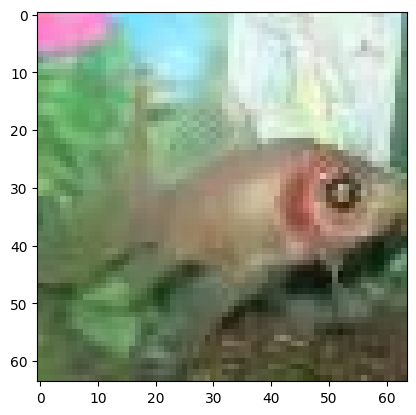

In [76]:
img = dataset['train'][0]['image']
plt.imshow(img)

In [77]:
print(f'Size: {img.size}')
print(f'Train: {len(trainset)}')
print(f'Test: {len(testset)}')
print(f'Classes: {len(set(trainset['label']))}')

Size: (64, 64)
Train: 100000
Test: 10000
Classes: 200


### Config

In [78]:
checkpoint_id = 1
folder_path = f'./Resnet/TinyImageNet/checkpoint{checkpoint_id}/'
kernel_size = 3
stride = 1
padding = 1
num_classes = len(set(trainset['label']))
batch_size = 128
num_epochs = 50
learning_rate = 0.001
step_size = 25

os.makedirs(folder_path, exist_ok=True)

config = {
    "checkpoint_id": checkpoint_id,
    "folder_path": folder_path,
    "kernel_size": kernel_size,
    "stride": stride,
    "padding": padding,
    "num_classes": num_classes,
    "batch_size": batch_size,
    "num_epochs": num_epochs,
    "learning_rate": learning_rate,
    "step_size": step_size
}

with open(folder_path + "config.json", "w") as f:
    json.dump(config, f, indent=4)

In [ ]:
model = Resnet34(kernel_size, stride, padding, num_classes).to(device)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.1)
print(model)

Resnet34(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2_x): Sequential(
    (0): BuildingBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BuildingBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), 

### Train, test

In [ ]:
def train(model, trainloader, criterion, optimizer, scheduler, device, folder_path, num_epochs=10):
    model.train()
    epoch_losses = []
    start = time.time()
    for epoch in tqdm(range(num_epochs)):
        running_loss = 0
        for i, (inputs, labels) in enumerate(trainloader, 0):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad() 

            outputs = model(inputs) 
            loss = criterion(outputs, labels)  
            loss.backward()
            optimizer.step() 

            running_loss += loss.item()
        running_loss = running_loss / len(trainloader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}')
        epoch_losses.append(running_loss)
        scheduler.step()
    end = time.time()
    training_time = (end - start) / 3600

    plt.plot(range(1, num_epochs + 1), epoch_losses)
    plt.title('Training Loss per Epoch')
    plt.suptitle(f'Training time: {training_time:.2f} hours')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig(folder_path + 'training_loss.png')
    plt.show()

    torch.save(model.state_dict(), folder_path + 'model_weights.pth')

def evaluate(model, testloader, device, folder_path):
    model.eval()
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    correct = sum([1 for a, p in zip(all_labels, all_predictions) if a == p])
    total = len(all_labels)
    accuracy = 100 * correct / total
    report = classification_report(all_labels, all_predictions)
    print(f'Accuracy: {accuracy:.2f}%')
    print("Classification Report:")
    print(report)

    with open(folder_path + 'report.txt', "w") as f:
        f.write(f'Accuracy: {accuracy:.2f}%\n')
        f.write("Classification Report:\n\n")
        f.write(report)
    

In [ ]:
train(model, trainloader, criterion, optimizer, scheduler, device, folder_path, num_epochs=num_epochs)

In [ ]:
evaluate(model, testloader, device, folder_path)